# Variational Autoencoders (VAEs)

## 🎯 Motivation: Image Generation

We want to build a model that can **generate realistic images** — like cats, digits, or landscapes.

Formally, this means sampling from some unknown data distribution:

$$
x \sim p(x)
$$

But the true distribution $p(x)$ over images is **unknown and highly complex**. So we want to **learn an approximate model** that can:

- Learn the structure of the data
- Generate new, realistic samples

## 🧠 Latent Variable Models

Instead of modeling $p(x)$ directly, we assume there's an **unobserved latent variable** $z$ that generates $x$.

We define a **generative model**:

$$
p_\theta(x, z) = p_\theta(x \mid z) \, p(z)
$$

- $p(z)$ is the **prior** over latent variables (usually standard normal)
- $p_\theta(x \mid z)$ is the **likelihood** or **decoder**, implemented as a neural network

The marginal likelihood is:

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

This model can **generate new images** by:

1. Sampling $z \sim p(z)$
2. Computing $x \sim p_\theta(x \mid z)$

## 🚧 Intractability: Why Not Just Maximize $\log p(x)$?

The integral

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$

is often **intractable**, because:

- $p_\theta(x \mid z)$ is defined by a neural net (not analytically integrable)
- $z$ is high-dimensional

This also makes the **posterior** $p(z \mid x)$ intractable:

$$
p(z \mid x) = \frac{p_\theta(x \mid z) p(z)}{p_\theta(x)}
$$

So we can't use exact maximum likelihood.

## 💡 Variational Inference

We introduce an **approximate posterior** $q_\phi(z \mid x)$ (called the encoder), to approximate the true posterior $p(z \mid x)$.

We optimize a lower bound on the log-likelihood, called the **Evidence Lower Bound (ELBO)**:

$$
\log p_\theta(x) \geq \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)] - D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

This gives us the **VAE loss function**:

- **Reconstruction term**: encourages decoding $z$ into $x$
- **KL divergence**: regularizes the latent space

## 🔧 VAE Loss Function

The variational objective we optimize is:

$$
\mathcal{L}_{\text{VAE}}(x) = - \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z)] + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

This balances:

- How well the model **reconstructs** the input from latent $z$
- How close the learned posterior is to the **prior**

## 🔁 Reparameterization Trick

To backpropagate through the sampling step $z \sim q_\phi(z \mid x)$, we use the **reparameterization trick**.

We assume the encoder outputs a Gaussian posterior:

$$
q_\phi(z \mid x) = \mathcal{N}(z; \mu_\phi(x), \text{diag}(\sigma^2_\phi(x)))
$$

Then we reparameterize sampling as:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling operation differentiable with respect to $\mu_\phi(x)$ and $\sigma_\phi(x)$.

## 📏 KL Divergence as a Regularizer

We use a standard normal prior:

$$
p(z) = \mathcal{N}(0, I)
$$

The KL divergence between $q_\phi(z \mid x)$ and $p(z)$ can be computed in closed form:

$$
D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z)) = \frac{1}{2} \sum_{j=1}^{d} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right)
$$

This term encourages the latent space to stay close to the prior — it acts as a **regularizer**.

## 🧪 Monte Carlo Estimation of the ELBO

The expectation in the reconstruction term:

$$
\mathbb{E}_{q_\phi(z \mid x)} [\log p_\theta(x \mid z)]
$$

is estimated using a **single sample** from the encoder:

$$
\log p_\theta(x \mid z) \approx \log p_\theta(x \mid z^{(1)}), \quad z^{(1)} \sim q_\phi(z \mid x)
$$

So the final training loss becomes:

$$
\mathcal{L}(x) \approx - \log p_\theta(x \mid z^{(1)}) + D_{\text{KL}}(q_\phi(z \mid x) \,\|\, p(z))
$$

We compute this with:

- Binary cross-entropy (for Bernoulli likelihood)
- MSE (for Gaussian likelihood)
- Analytical KL for the latent space

## ⚙️ Likelihood Assumptions and Loss Types

The reconstruction term depends on the form of $p_\theta(x \mid z)$. Common choices are:

| Likelihood  | Use Case                    | Decoder Output                       | Reconstruction Loss      |
| ----------- | --------------------------- | ------------------------------------ | ------------------------ |
| Bernoulli   | Binary pixels (e.g., MNIST) | Sigmoid-activated values in $[0, 1]$ | Binary cross-entropy     |
| Gaussian    | Continuous values           | Raw real-valued output               | Mean squared error (MSE) |
| Categorical | Discretized/tokens          | Logits for each class per pixel      | Cross-entropy            |

You should choose the likelihood that matches your data:

- Use **Bernoulli** for grayscale MNIST
- Use **Gaussian** if you treat pixel intensities as continuous
- Use **Categorical** only if the data is quantized or tokenized


### Code example for Bernoulli and Gaussian likelihood

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Encoder: x -> z (mean and logvar)
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# Decoder: z -> x_hat
class Decoder(nn.Module):
    def __init__(
        self, latent_dim=20, hidden_dim=400, output_dim=784, likelihood="bernoulli"
    ):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.likelihood = likelihood

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = self.fc_out(h)
        if self.likelihood == "bernoulli":
            return torch.sigmoid(out)  # probability of pixel being white
        elif self.likelihood == "categorical":
            return out.view(-1, 10, 784 // 10)  # logits for each class
        else:  # "gaussian"
            return out  # raw output; assume Gaussian mean


class VAE(nn.Module):
    def __init__(
        self, input_dim=784, hidden_dim=400, latent_dim=20, likelihood="bernoulli"
    ):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, likelihood)
        self.likelihood = likelihood

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


def vae_loss(x, x_hat, mu, logvar, likelihood="bernoulli"):
    if likelihood == "bernoulli":
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    elif likelihood == "gaussian":
        recon_loss = F.mse_loss(x_hat, x, reduction="sum")
    else:
        raise ValueError(f"Unknown likelihood type: {likelihood}")

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


def run_training(likelihood: str, epochs: int = 100, every_nth: int = 10):

    transform = transforms.ToTensor()
    train_loader = DataLoader(
        datasets.MNIST(root="./data", train=True, download=True, transform=transform),
        batch_size=1024,
        shuffle=True,
    )

    # Initialize model, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vae = VAE(likelihood=likelihood).to(device)
    optimizer = torch.optim.Adam(vae.parameters())

    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for x, _ in train_loader:
            x = x.view(-1, 784).to(device)
            x_hat, mu, logvar = vae(x)

            loss = vae_loss(x, x_hat, mu, logvar, likelihood)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if epoch % every_nth == 0 or epoch == epochs - 1:
            vae.eval()
            with torch.no_grad():
                z = torch.randn(16, 20).to(device)
                samples = vae.decoder(z)
                samples = samples.cpu().view(-1, 1, 28, 28)
                grid = torchvision.utils.make_grid(samples, nrow=4)
                plt.figure(figsize=(4, 4))
                plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
                plt.title(f"Generated Samples (Epoch {epoch+1})")
                plt.axis("off")
                plt.show()

Epoch 1, Loss: 258.1474


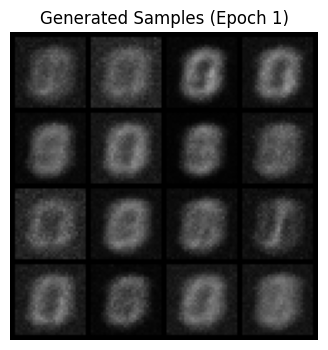

Epoch 2, Loss: 183.7823
Epoch 3, Loss: 156.2015
Epoch 4, Loss: 142.7721
Epoch 5, Loss: 133.7757
Epoch 6, Loss: 128.0458
Epoch 7, Loss: 124.0956
Epoch 8, Loss: 121.3591
Epoch 9, Loss: 119.2035
Epoch 10, Loss: 117.5500
Epoch 11, Loss: 116.2052


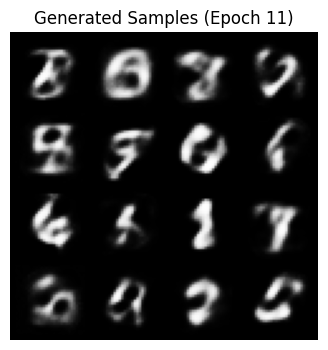

Epoch 12, Loss: 114.9566
Epoch 13, Loss: 113.9893
Epoch 14, Loss: 113.1935
Epoch 15, Loss: 112.4968
Epoch 16, Loss: 111.7982
Epoch 17, Loss: 111.3074
Epoch 18, Loss: 110.7672
Epoch 19, Loss: 110.3271
Epoch 20, Loss: 109.9276
Epoch 21, Loss: 109.5268


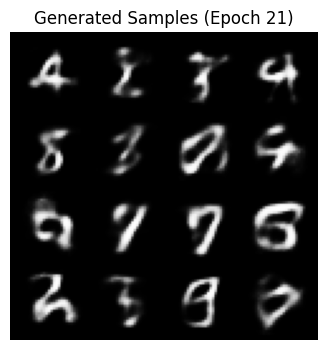

Epoch 22, Loss: 109.2039
Epoch 23, Loss: 108.8588
Epoch 24, Loss: 108.5844
Epoch 25, Loss: 108.3052
Epoch 26, Loss: 108.0441
Epoch 27, Loss: 107.8188
Epoch 28, Loss: 107.5786
Epoch 29, Loss: 107.4563
Epoch 30, Loss: 107.2131
Epoch 31, Loss: 106.9942


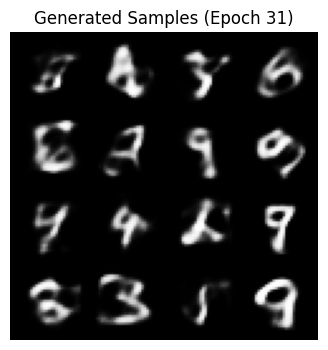

Epoch 32, Loss: 106.8359
Epoch 33, Loss: 106.6424
Epoch 34, Loss: 106.4812
Epoch 35, Loss: 106.4121
Epoch 36, Loss: 106.2094
Epoch 37, Loss: 106.0726
Epoch 38, Loss: 105.9374
Epoch 39, Loss: 105.8740
Epoch 40, Loss: 105.7324
Epoch 41, Loss: 105.5680


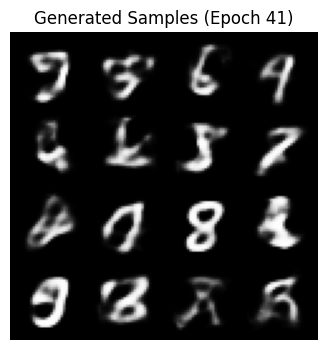

Epoch 42, Loss: 105.4787
Epoch 43, Loss: 105.4421
Epoch 44, Loss: 105.2950
Epoch 45, Loss: 105.1926
Epoch 46, Loss: 105.1420
Epoch 47, Loss: 105.0450
Epoch 48, Loss: 104.9696
Epoch 49, Loss: 104.8751
Epoch 50, Loss: 104.7827
Epoch 51, Loss: 104.6691


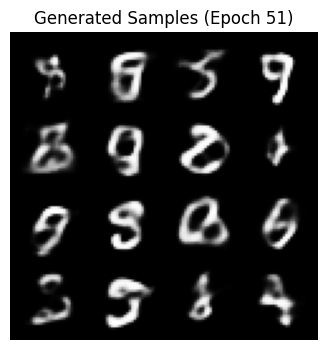

Epoch 52, Loss: 104.5968
Epoch 53, Loss: 104.5130
Epoch 54, Loss: 104.4177
Epoch 55, Loss: 104.3607
Epoch 56, Loss: 104.3525
Epoch 57, Loss: 104.2695
Epoch 58, Loss: 104.1904
Epoch 59, Loss: 104.1770
Epoch 60, Loss: 104.0551
Epoch 61, Loss: 104.0065


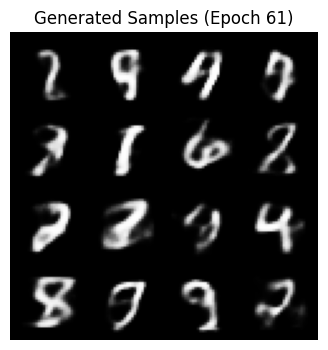

Epoch 62, Loss: 103.9629
Epoch 63, Loss: 103.9271
Epoch 64, Loss: 103.8330
Epoch 65, Loss: 103.7831
Epoch 66, Loss: 103.7277
Epoch 67, Loss: 103.7171
Epoch 68, Loss: 103.5869
Epoch 69, Loss: 103.5692
Epoch 70, Loss: 103.5723
Epoch 71, Loss: 103.4572


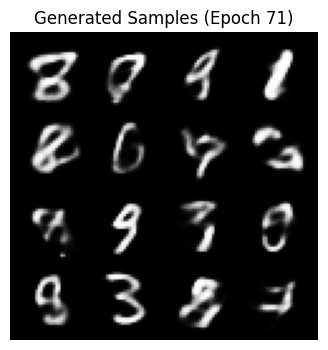

Epoch 72, Loss: 103.3959
Epoch 73, Loss: 103.4133
Epoch 74, Loss: 103.3536
Epoch 75, Loss: 103.2929
Epoch 76, Loss: 103.2627
Epoch 77, Loss: 103.2588
Epoch 78, Loss: 103.1526
Epoch 79, Loss: 103.1072
Epoch 80, Loss: 103.0660
Epoch 81, Loss: 103.0941


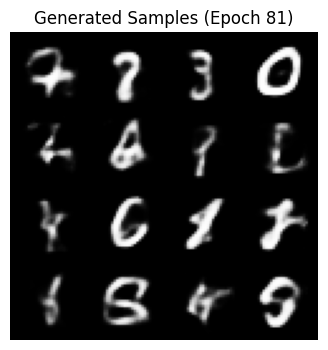

Epoch 82, Loss: 103.0222
Epoch 83, Loss: 102.9678
Epoch 84, Loss: 102.9600
Epoch 85, Loss: 102.9005
Epoch 86, Loss: 102.8504
Epoch 87, Loss: 102.7871
Epoch 88, Loss: 102.7990
Epoch 89, Loss: 102.7614
Epoch 90, Loss: 102.7556
Epoch 91, Loss: 102.7247


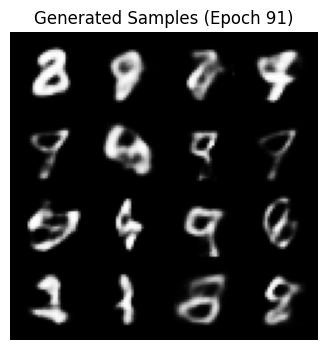

Epoch 92, Loss: 102.6768
Epoch 93, Loss: 102.6070
Epoch 94, Loss: 102.5902
Epoch 95, Loss: 102.5466
Epoch 96, Loss: 102.5513
Epoch 97, Loss: 102.4971
Epoch 98, Loss: 102.4764
Epoch 99, Loss: 102.4099
Epoch 100, Loss: 102.3641


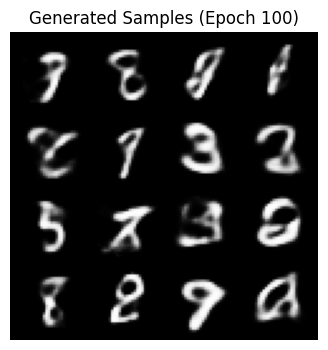

In [2]:
run_training("bernoulli", epochs=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3047407..1.0718493].


Epoch 1, Loss: 59.8825


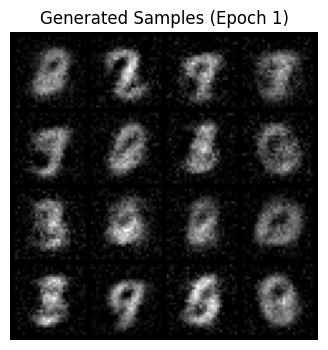

Epoch 2, Loss: 43.2128
Epoch 3, Loss: 39.3192
Epoch 4, Loss: 37.4383
Epoch 5, Loss: 36.3114
Epoch 6, Loss: 35.5867
Epoch 7, Loss: 35.0751
Epoch 8, Loss: 34.7246
Epoch 9, Loss: 34.4562
Epoch 10, Loss: 34.1922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4254655..1.3819191].


Epoch 11, Loss: 33.9453


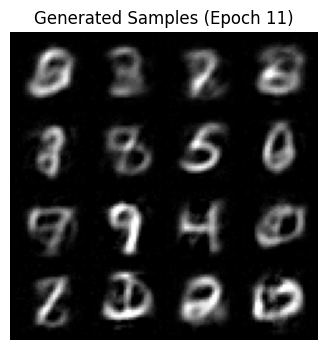

Epoch 12, Loss: 33.7579
Epoch 13, Loss: 33.6185
Epoch 14, Loss: 33.4881
Epoch 15, Loss: 33.3227
Epoch 16, Loss: 33.1939
Epoch 17, Loss: 33.0593
Epoch 18, Loss: 32.9451
Epoch 19, Loss: 32.8319
Epoch 20, Loss: 32.7069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32202926..1.3987783].


Epoch 21, Loss: 32.6003


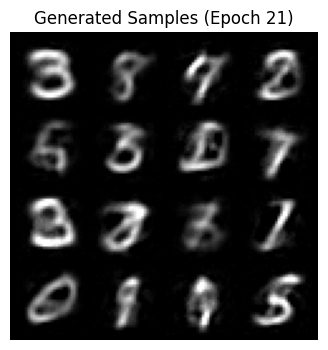

Epoch 22, Loss: 32.5057
Epoch 23, Loss: 32.4291
Epoch 24, Loss: 32.3354
Epoch 25, Loss: 32.2618
Epoch 26, Loss: 32.1383
Epoch 27, Loss: 32.0875
Epoch 28, Loss: 32.0299
Epoch 29, Loss: 31.9578
Epoch 30, Loss: 31.8811


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32791603..1.3036064].


Epoch 31, Loss: 31.8362


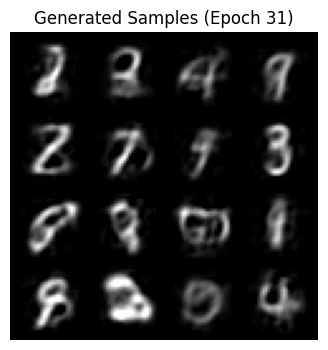

Epoch 32, Loss: 31.7824
Epoch 33, Loss: 31.7420
Epoch 34, Loss: 31.6468
Epoch 35, Loss: 31.6158
Epoch 36, Loss: 31.5664
Epoch 37, Loss: 31.5099
Epoch 38, Loss: 31.4954
Epoch 39, Loss: 31.4133
Epoch 40, Loss: 31.3819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7135788..1.3418261].


Epoch 41, Loss: 31.3176


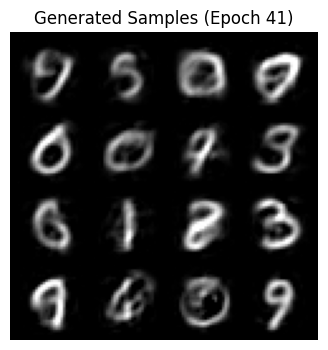

Epoch 42, Loss: 31.3330
Epoch 43, Loss: 31.2666
Epoch 44, Loss: 31.2727
Epoch 45, Loss: 31.1983
Epoch 46, Loss: 31.1677
Epoch 47, Loss: 31.1393
Epoch 48, Loss: 31.1064
Epoch 49, Loss: 31.0632
Epoch 50, Loss: 31.0242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39670926..1.3347528].


Epoch 51, Loss: 30.9870


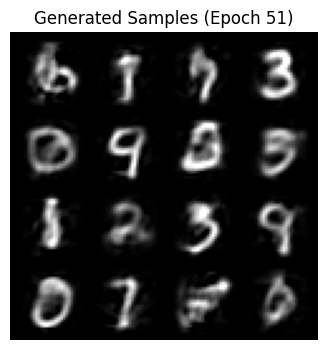

Epoch 52, Loss: 30.9564
Epoch 53, Loss: 30.9585
Epoch 54, Loss: 30.9331
Epoch 55, Loss: 30.8865
Epoch 56, Loss: 30.8852
Epoch 57, Loss: 30.8571
Epoch 58, Loss: 30.8200
Epoch 59, Loss: 30.7944
Epoch 60, Loss: 30.7894


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24917051..1.417025].


Epoch 61, Loss: 30.7547


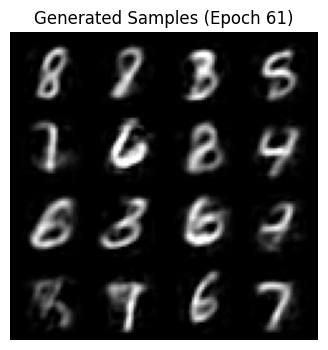

Epoch 62, Loss: 30.7421
Epoch 63, Loss: 30.6984
Epoch 64, Loss: 30.6971
Epoch 65, Loss: 30.6873
Epoch 66, Loss: 30.6354
Epoch 67, Loss: 30.6337
Epoch 68, Loss: 30.6080
Epoch 69, Loss: 30.5860
Epoch 70, Loss: 30.5585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4250928..1.2619377].


Epoch 71, Loss: 30.5555


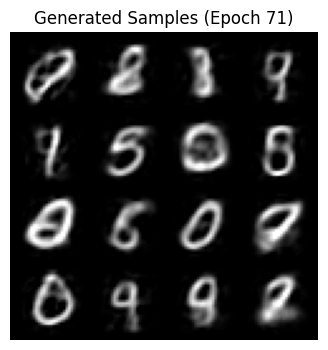

Epoch 72, Loss: 30.5632
Epoch 73, Loss: 30.5255
Epoch 74, Loss: 30.5173
Epoch 75, Loss: 30.5036
Epoch 76, Loss: 30.4659
Epoch 77, Loss: 30.4559
Epoch 78, Loss: 30.4909
Epoch 79, Loss: 30.4402
Epoch 80, Loss: 30.3972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38219622..1.3124567].


Epoch 81, Loss: 30.4043


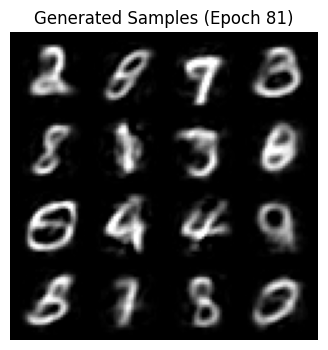

Epoch 82, Loss: 30.3965
Epoch 83, Loss: 30.3834
Epoch 84, Loss: 30.3775
Epoch 85, Loss: 30.3553
Epoch 86, Loss: 30.3296
Epoch 87, Loss: 30.3479
Epoch 88, Loss: 30.2951
Epoch 89, Loss: 30.3024
Epoch 90, Loss: 30.3159


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4470945..1.2303205].


Epoch 91, Loss: 30.3049


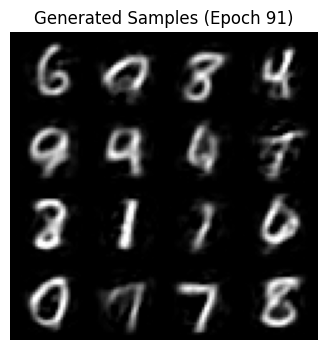

Epoch 92, Loss: 30.3066
Epoch 93, Loss: 30.2722
Epoch 94, Loss: 30.2555
Epoch 95, Loss: 30.2164
Epoch 96, Loss: 30.2255
Epoch 97, Loss: 30.2186
Epoch 98, Loss: 30.1992
Epoch 99, Loss: 30.2160


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40476954..1.6224698].


Epoch 100, Loss: 30.1787


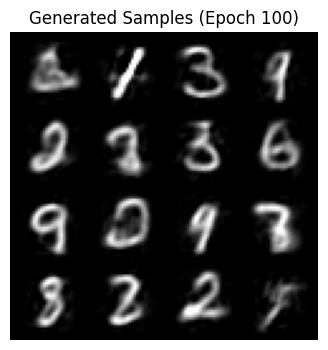

In [3]:
run_training("gaussian", epochs=100)